# Data Cleaning for Restaurant Recommender

This script covers the ETL for the Yelp review data. Key steps are outlined here:
- Business data is loaded in.  Business category is parsed and filtered to just Restaurants.
- Reviews are loaded and investigated.  Reviews are counted by city to pick a suitable city.
- Toronto is chosen as a suitable city, review set is restricted to just Toronto.
- Users who have made more than 10 reviews in 2014-18 are selected as 'power-users' to inform the FunkSVD model.

**NB this file has been refactored to only include relevant EDA.**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Data</a></span><ul class="toc-item"><li><span><a href="#Business-data" data-toc-modified-id="Business-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Business data</a></span><ul class="toc-item"><li><span><a href="#Removing-Null-Data" data-toc-modified-id="Removing-Null-Data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Removing Null Data</a></span></li><li><span><a href="#Pulling-out-Restaurants-from-all-businesses" data-toc-modified-id="Pulling-out-Restaurants-from-all-businesses-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Pulling out Restaurants from all businesses</a></span></li><li><span><a href="#Keep-only-the-Toronto-restaurants" data-toc-modified-id="Keep-only-the-Toronto-restaurants-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Keep only the Toronto restaurants</a></span></li></ul></li><li><span><a href="#Review-&amp;-ratings-data" data-toc-modified-id="Review-&amp;-ratings-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Review &amp; ratings data</a></span><ul class="toc-item"><li><span><a href="#Filter-to-just-Toronto-reviews" data-toc-modified-id="Filter-to-just-Toronto-reviews-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Filter to just Toronto reviews</a></span></li><li><span><a href="#Decide-which-users-to-include-in-the-training/testing-set" data-toc-modified-id="Decide-which-users-to-include-in-the-training/testing-set-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Decide which users to include in the training/testing set</a></span></li></ul></li><li><span><a href="#Visualisation-of-final-cleaned-review-data" data-toc-modified-id="Visualisation-of-final-cleaned-review-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Visualisation of final cleaned review data</a></span></li><li><span><a href="#Encode-IDs-(optional)" data-toc-modified-id="Encode-IDs-(optional)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Encode IDs (optional)</a></span></li><li><span><a href="#Output-cleaned-data-to-JSON" data-toc-modified-id="Output-cleaned-data-to-JSON-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Output cleaned data to JSON</a></span></li></ul></li></ul></div>

## Loading Data

Data from [Yelp](https://www.kaggle.com/yelp-dataset/yelp-dataset?select=yelp_academic_dataset_business.json)

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numba
import folium
from folium import Choropleth, Circle, Marker, Popup
from folium.plugins import HeatMap, MarkerCluster
import math

In [3]:
def pick_lines_and_load(line):
    '''
    Args:
    Returns:
    '''
    line_json = json.loads(line)
    line = dict( [k,v] for k,v in line_json.items() if k in columns_to_keep) 
    return line
    
def read_in_json(filepath):
    '''The Yelp json files are one json per row, so 
    Args:
    Returns:
    
    '''
    with open(filepath) as json_file:      
        data = json_file.readlines()
        data = list(map(pick_lines_and_load, data)) 

    return pd.DataFrame(data)

def get_file_structure(filepath):
    '''Gets the file structure of the input file by reading a single line 
    Args:
    Returns:
    
    '''
    with open(filepath) as json_file:      
        data = json_file.readlines(1)
        data = list(map(json.loads, data)) 

    return pd.DataFrame(data)

### Business data
Read the first line of each file to understand the json structure and which columns we want to keep

In [37]:
get_file_structure('../../../YelpData/yelp_academic_dataset_business.json')
columns_to_keep = ['business_id','name','city','latitude','longitude','review_count','categories']

In [38]:
df_businesses = read_in_json('../../../YelpData/yelp_academic_dataset_business.json')
df_businesses.head()

,business_id,name,city,latitude,longitude,review_count,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,Cornelius,35.462724,-80.852612,36,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD",Scottsdale,33.569404,-111.890264,4,"Health & Medical, Fitness & Instruction, Yoga,..."
2,XNoUzKckATkOD1hP6vghZg,Felinus,Montreal,45.479984,-73.580070,5,"Pets, Pet Services, Pet Groomers"
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,North Las Vegas,36.219728,-115.127725,3,"Hardware Stores, Home Services, Building Suppl..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,Mesa,33.428065,-111.726648,26,"Home Services, Plumbing, Electricians, Handyma..."


#### Removing Null Data

In [39]:
# How many nulls in each columns?
df_businesses.isna().mean()

business_id     0.000000
name            0.000000
city            0.000000
latitude        0.000000
longitude       0.000000
review_count    0.000000
categories      0.002502
dtype: float64

In [40]:
# Drop businesses without a category
df_businesses.dropna(subset = ['categories'], inplace=True)
df_businesses.isna().mean()

business_id     0.0
name            0.0
city            0.0
latitude        0.0
longitude       0.0
review_count    0.0
categories      0.0
dtype: float64

Categories are in a comma-separated list, break them apart and keep only those rows that contain the `Restaurants` category

#### Pulling out Restaurants from all businesses

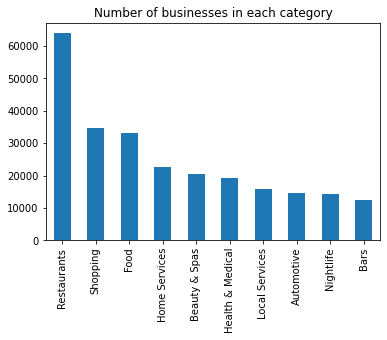

In [41]:
categories = df_businesses.categories.str.split(',').explode().str.strip()
categories.value_counts()[:10].plot(kind='bar');
plt.title('Number of businesses in each category');

In [10]:
# Keep only business which contain Restaurant in their category list
df_businesses = df_businesses[df_businesses.categories.str.split(',').apply(lambda x: 'Restaurants' in x)]
df_businesses.shape

(19456, 7)

#### Keep only the Toronto restaurants

In [11]:
df_businesses_toronto = df_businesses[df_businesses.city == 'Toronto']

In [59]:
# Create a base map
m_1 = folium.Map(location=[43.716805,-79.400696], tiles='cartodbpositron', zoom_start=11)

# Add a heatmap to the base map
HeatMap(data=df_businesses_toronto[['latitude', 'longitude']], radius=14).add_to(m_1)

# Display the map
m_1.save('images/toronto.html')
m_1

### Review & ratings data

In [13]:
review_filepath = '../../../YelpData/yelp_academic_dataset_review.json'
get_file_structure(review_filepath)
columns_to_keep = ['review_id','user_id','business_id','stars','useful','funny','cool','date']

In [14]:
df_reviews = read_in_json(review_filepath)
df_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,2017-01-14 21:56:57


In [15]:
# Pull in the city information for each review, to enable city filtering
df_reviews_city = df_reviews.merge(df_businesses[['business_id','city']], on='business_id')

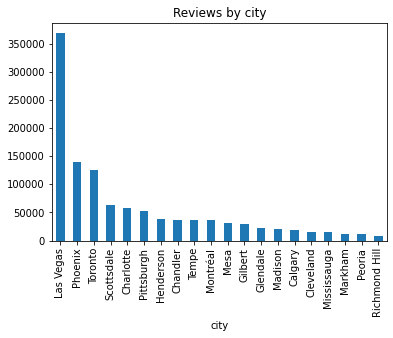

In [34]:
# How many reviews for each city?
city_counts = df_reviews_city.groupby('city').review_id.count()
city_counts.sort_values(ascending = False)[:20].plot(kind = 'bar');
plt.title('Reviews by city');

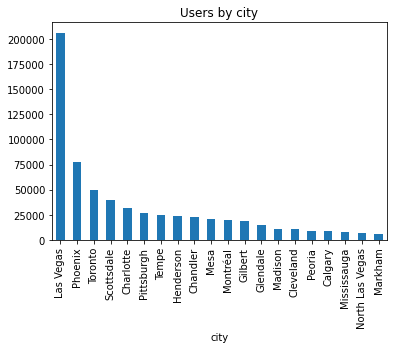

In [35]:
# How many users for each city?
user_counts = df_reviews_city.groupby('city').user_id.nunique()
user_counts.sort_values(ascending = False)[:20].plot(kind = 'bar');
plt.title('Users by city');

#### Filter to just Toronto reviews

In [18]:
toronto_reviews = df_reviews_city[df_reviews_city.city == 'Toronto']
toronto_reviews.shape

(125432, 9)

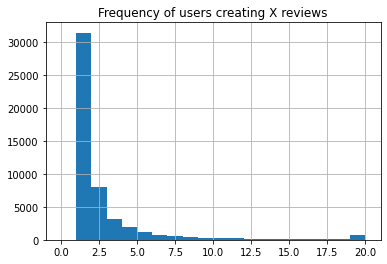

In [33]:
# For plotting purposes, cap reviews-per-user counts at 20
user_counts = toronto_reviews.groupby('user_id').review_id.count()
user_counts[user_counts > 20] = 20
user_counts.hist(bins = np.arange(21));
plt.title('Frequency of users creating X reviews');

In [20]:
print('In Toronto there are {} businesses and {} reviewing users' \
      .format(toronto_reviews.business_id.nunique(),toronto_reviews.user_id.nunique()))

In Toronto there are 2707 businesses and 49549 reviewing users


In [61]:
# Change datetime column from object to date
toronto_reviews['year'] = pd.to_datetime(toronto_reviews.date).dt.year
toronto_reviews['date'] = pd.to_datetime(toronto_reviews.date).dt.date


/Users/paulgstubley/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/paulgstubley/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


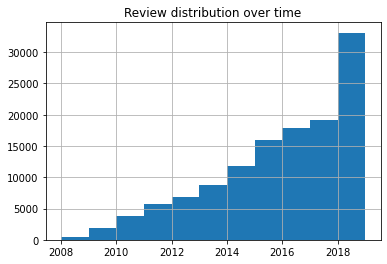

In [32]:
# How are the number of reviews distributed over time
toronto_reviews.year.hist(bins=np.arange(2008,2020))
plt.title('Review distribution over time');

#### Decide which users to include in the training/testing set

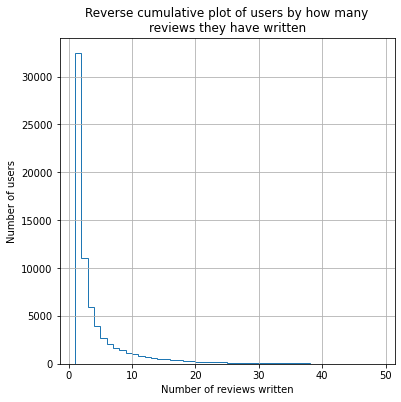

In [51]:
# We ignore very old reviews
toronto_reviews_sub = toronto_reviews[toronto_reviews.year>2014]

# We will use 2019 as our test set, so for the following we care just about pre-2019 reviews
user_counts = toronto_reviews_sub[toronto_reviews_sub.year<2019].groupby('user_id').review_id.count()

# To choose a cut-off for minimum reviews-per-user, we can use a reverse-cumulative plot

# How are the reviews made up?  The vast majority come from users who reviews just once.
# These users won't be much use for SVD.  We can see that ~1_000 users have
# reviewed 10 or more times, I will use just these ones to begin with.
user_counts.hist(histtype='step',cumulative=-1, bins=np.arange(1,50), figsize = (6,6))
plt.title('Reverse cumulative plot of users by how many\nreviews they have written');
plt.xlabel('Number of reviews written')
plt.ylabel('Number of users')

number_of_reviews = []

for n in range(0,51,5):
    top_users = user_counts[user_counts>=n].index
    number_of_reviews.append([n,toronto_reviews_sub[(toronto_reviews_sub.year<2019) & (toronto_reviews_sub.user_id.isin(top_users))].shape[0]])

number_of_reviews = np.array(number_of_reviews)
    

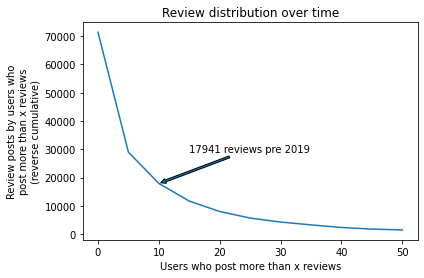

In [45]:
plt.plot(number_of_reviews[:,0],number_of_reviews[:,1])
plt.ylabel('Review posts by users who\npost more than x reviews\n(reverse cumulative)')
plt.xlabel('Users who post more than x reviews');

# Who is defined as a power_user
keep = 10
keep_id = int(keep/5)
plt.annotate(s = '{} reviews pre 2019'.format(number_of_reviews[keep_id,1])
             , xy = (number_of_reviews[keep_id,0],number_of_reviews[keep_id,1])
             , xytext = (number_of_reviews[keep_id+1,0],number_of_reviews[keep_id-1,1])
             , arrowprops = {'arrowstyle': 'simple'});
plt.title('Review distribution over time');

In [55]:
# Cut the review df to just those users who've made 10 or more reviews between 2014-2018 inc
top_users = user_counts[user_counts>=keep]
toronto_reviews_sub = toronto_reviews_sub[toronto_reviews_sub.user_id.isin(top_users.index)]

In [56]:
print('{} power users with {} reviews (2015-19) for {} restaurants'.format(len(top_users), toronto_reviews_sub.shape[0],  toronto_reviews_sub.business_id.nunique()))


1019 power users with 20390 reviews (2015-19) for 1943 restaurants


### Visualisation of final cleaned review data

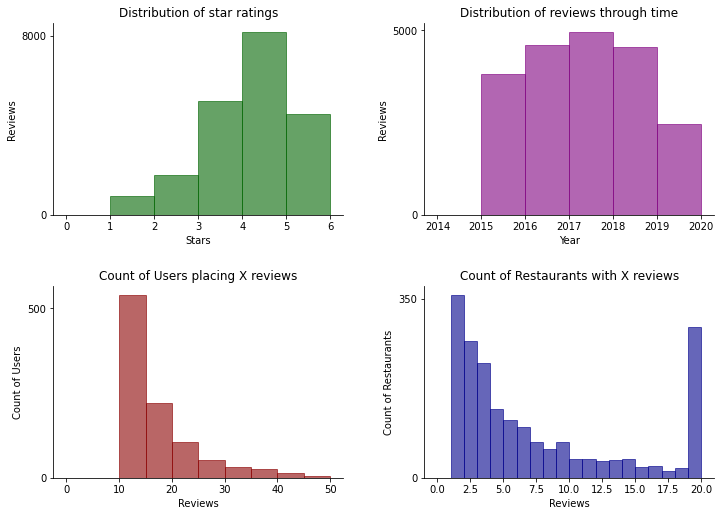

In [57]:
def format_chart(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    toptick = [ax.get_yticks()[0]]+[ax.get_yticks()[-2]]
    ax.set_yticks(toptick)

fig,ax = plt.subplots(2,2, figsize = (11,8))
fig.tight_layout(pad = 5.0)

toronto_reviews_sub.stars.hist(bins=range(7), color = 'darkgreen', ax=ax[0][0], alpha=0.6, edgeColor = 'darkgreen')
format_chart(ax[0][0], 'Distribution of star ratings','Stars','Reviews')

toronto_reviews_sub.year.hist(bins = np.arange(2014,2021,1), ax=ax[0][1] , alpha = 0.6, color = 'purple', edgeColor = 'purple')
format_chart(ax[0][1], 'Distribution of reviews through time','Year','Reviews')

top_users.hist(bins = np.arange(0,51,5), ax=ax[1][0], color = 'darkred', alpha = 0.6, edgeColor = 'darkred')
format_chart(ax[1][0], 'Count of Users placing X reviews','Reviews','Count of Users')

business_counts = toronto_reviews_sub.groupby('business_id').review_id.count()
business_counts[business_counts > 20] = 20      

business_counts.hist(bins = np.arange(21), ax=ax[1][1], color = 'darkblue', alpha = 0.6, edgeColor = 'darkblue')
format_chart(ax[1][1], 'Count of Restaurants with X reviews','Reviews','Count of Restaurants')

### Encode IDs (optional)
Encode business_id, user_id and review_id as integer keys *(this step is optional to clean up the id keys)*
TODO: to future proof I'll need to pass all new data through this mapper function with the corresponding coded_dict

In [28]:
# def id_mapper(df, column, coded_dict=dict()):
#     '''Takes arbirtrary keys in a column, of any type, and encodes them as int
#     Args:
#         df - (pd.DataFrame) Dataframe of input values
#         column - (string) Column name to encode
#         coded_dict - (optional dict()) existing dict to use/add-to
#     Returns:
#         column_encoded - (list) the encoded values
#         coded_dict - (dict) the dictionary to keep for future encodings
#     '''
#     coded_dict = dict()
#     cter = 1
#     column_encoded = []
    
#     for val in df[column]:
#         if val not in coded_dict:
#             coded_dict[val] = cter
#             cter +=1
        
#         column_encoded.append(coded_dict[val])
#     return column_encoded, coded_dict

In [29]:
# toronto_reviews_sub['review_id'] = id_mapper(toronto_reviews_sub,'review_id')[0]
# toronto_reviews_sub['user_id'] = id_mapper(toronto_reviews_sub,'user_id')[0]
# toronto_reviews_sub['business_id'] = id_mapper(toronto_reviews_sub,'business_id')[0]

# toronto_reviews_sub.head()

### Output cleaned data to JSON

In [30]:
toronto_reviews_sub.to_json('data/toronto_reviews_sub.json', orient='records')
df_businesses_toronto.to_json('data/businesses_toronto.json', orient='records')